In [51]:
import json
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
# import torch
# import torch.nn as nn
# import torch

In [52]:
# Replace with your own path
df = pd.read_csv('/Users/timwu0/Documents/CS329P/afterhours_crypto/preprocessing/crypto_data.csv')
coins = df['coin'].unique()
print(coins)

#convert coin to one-hot vectors
for coin in coins:
    df[coin] = df['coin'] == coin

def train_test_split(df, test_val_size=0.15):
    train_data = pd.DataFrame(columns=df.columns)
    test_data = pd.DataFrame(columns=df.columns)
    for coin in coins:
        df_coin = df.loc[df['coin'] == coin]
        split_row_val = len(df_coin) - int(2 * test_val_size * len(df_coin))
        split_row_test = len(df_coin) - int(test_val_size * len(df_coin))
        
        train_data = pd.concat([train_data, df_coin.iloc[:split_row_val]]) 
        val_data = pd.concat([train_data, df_coin.iloc[split_row_val:split_row_test]]) 
        test_data = pd.concat([test_data, df_coin.iloc[split_row_test:]])
        # print(train_data.tail())
    
    # print(train_data.columns)
    mean_p = train_data['p'].mean()
    std_p = train_data['p'].std()
    train_data['p'] = (train_data['p']-mean_p)/std_p
    val_data['p'] = (val_data['p']-mean_p)/std_p
    test_data['p'] = (test_data['p']-mean_p)/std_p
    

    return train_data.drop(['coin'], axis=1), val_data.drop(['coin'], axis=1), test_data.drop(['coin'], axis=1)
train, val, test = train_test_split(df, test_val_size=0.15)
print(train, val, test)

['BTC-USD' 'ETH-USD' 'SOL1-USD' 'BNB-USD' 'DOT1-USD' 'ADA-USD' 'XRP-USD'
 'DOGE-USD' 'SHIB-USD' 'AVAX-USD' 'LTC-USD' 'XMR-USD' 'ETC-USD' 'REP-USD'
 'MAID-USD' 'STEEM-USD']
             date         high          low         open        close  \
0      1483228800  1003.080017   958.698975   963.658020   998.325012   
1      1483315200  1031.390015   996.702026   998.617004  1021.750000   
2      1483401600  1044.079956  1021.599976  1021.599976  1043.839966   
3      1483488000  1159.420044  1044.400024  1044.400024  1154.729980   
4      1483574400  1191.099976   910.416992  1156.729980  1013.380005   
...           ...          ...          ...          ...          ...   
22084  1591142400     0.206851     0.202184     0.205303     0.206851   
22085  1591228800     0.208996     0.203901     0.207062     0.208446   
22086  1591315200     0.210228     0.206634     0.208415     0.208746   
22087  1591401600     0.216520     0.206770     0.208746     0.214851   
22088  1591488000     0.2

[3388 rows x 24 columns]


In [55]:
window_len = 10
test_val_size = 0.15

def extract_window_data(df, window_len):
    window_data = []
    
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len, test_val_size):
    train_data, val_data, test_data = train_test_split(df, test_val_size=test_val_size)
    # print(train_data.shape)
    x_train = extract_window_data(train_data, window_len)
    # print(X_train.shape)
    x_val = extract_window_data(val_data, window_len) 
    x_test = extract_window_data(test_data, window_len)
    
    y_train = train_data[target_col][window_len:].values
    y_val = val_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values

    #print(len(train_data[target_col][:-window_len].values-1))
    #print(len(y_train))
    
    # print(X_train, y_train)

    return train_data, val_data, test_data, x_train, x_val, x_test, y_train, y_val, y_test
train, val, test, x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(df, 'p', window_len, test_val_size)

In [69]:
from rnn_model import rnn

features = tf.convert_to_tensor(x_train, dtype=tf.float32)
labels = tf.expand_dims(tf.convert_to_tensor(y_train, dtype=tf.float32), axis=1)

model = rnn(features=features, 
            labels=labels, 
            dropout=0.5, 
            num_layers=1, 
            size=128, 
            dense_units=1, 
            technicals=False)

AttributeError: module 'tensorflow' has no attribute 'contrib'

[0.05437028 0.05269592 0.05437028 0.05269592 0.05437028 0.05437028
 0.05437028 0.05437028 0.05437028 0.05437028]
[ 0.51766786  0.18543586  0.01104381  0.05990321  1.29474603  0.91591651
  0.1390815   0.38077704 -0.28795699 -0.46204294]
0.03088623990148595 -0.007981603 0.038867843633250534


0.7011721542678832

In [ ]:
print(preds[0:10])
print(y_test[:10])

print(y_test.mean(), preds.mean(), (y_test - preds).mean())
mean_absolute_error(preds, y_test)

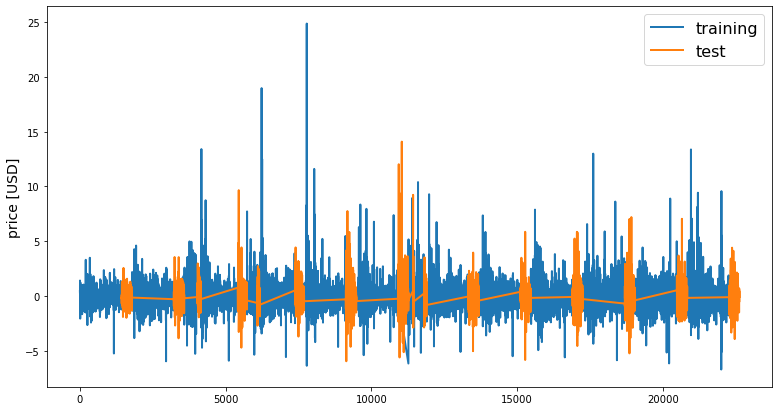

In [8]:
for coin in coins:
    
    